# Introduction and Problem Context

The "Gaza War" is one of the deadliest conflicts in the 21st century and has resulted in the direct deaths of over 70,000 Palestinians and over 171,000 Palestininans injured in Gaza as of December 1, 2025. The goal of this project is to use publicly available data to forecast the number of deaths, the number of injuries, the number of buildings destroyed, and the number of buildings damaged in Gaza over a three month period, starting from the current month. The reason why predictions start from the current month, instead of next month, is because data for these counts may be incomplete until the end of the month, and so the last complete month is used as the last datum for these predictions.

# Ethical Considerations

This data is extremely sensitive, not only because of the politicized nature of the Palestinian context, but also because of the sheer fact that every single data point is a lower dimensional representation of a human life. Each death recorded made a heartbreaking, negative impact in the lives of many more. Each injury recorded represents a permanent change in the lives of the injured and their loved ones, and whatever traumas may have arisen from that experience. Every building damaged needed or now needs to be repaired in a territory where the necessary resources are hard to come by and where, at any time, more damage could occur even if rebuilding were to occur, while every building destroyed results in a negative, permanent change in the lives involved. Entire families, loved ones, lives, and memories, lost due to war. It is important to have this level of empathy and understanding when viewing and interpreting this data, and to be sensitive to the realities of what each data point meaningfully represents.

# Methodology
Using the death toll, injury toll, damaged building, or destroyed building counts from Gaza as inputs, the Auto ARIMA (Autoregressive integrated moving average) library from the <a href="https://pypi.org/project/pmdarima/" target="_blank">pmdarima library</a> is used as the basis for these forecasts. The main statistical technique used in this model, called autoregression, builds upon the logic of autoregressive moving average (ARMA) and functions on non-stationary time series data. This is the most acceptable solution for time series on <a href="https://techforpalestine.org/">Tech for Palestine's</a> data on casualty counts and building damage in Gaza due to the ongoing data collection involved in that project. As a result, large fluctuations are found on a daily basis for these datasets due to the instability of the current iteration of what has been called the "Gaza War". Because of these large fluctuations, data is aggregated by month, rather than explored daily, to improve accuracy and mitigate variance that may come as a result of noise. 

After fitting the time series data to new instances of the ARIMA model, differencing is used to remove potential underlying trends to convert the non-stationary time series into a stationary time series for the sake of forecasting. This accounts for potential issues, such as seasonal trends that may be implicitly found in the data. Using death count data, for instance, ARIMA autoregresses on the current monthly death count data, uses a moving average of death counts to determine the next prediction per unit of measure (a month), and integrates value differences (instead of raw death count values) from one month to the next. This results in a three month period of predictions based off of the previous monthly data available per model.

# Implementation

## Imports and Installations

Seaborn and Matplotlib are libraries that provide visualization capabilities for this data, while the NumPy and Pandas libraries provide the core functionalities for data manipulation and transformation, with Statsmodels adding linear regressive capabilities for use in modeling and pmdarima providing forecasting tools using each dataset.

In [1]:
# Install ARIMA and other dependencies if not already installed
%pip install seaborn
%pip install pmdarima


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pmdarima import auto_arima

## Optimized ARIMA Prediction Function

The optimized ARIMA prediction function used in the "improved_forecast" function takes in a dataframe (denoting one of the datasets used for prediction), specifies which column denotes time and which column denotes the values, the number of steps (units of time), denoting a "seasonal" value of false, and denotes the number of months as "m". This function prepares the data by creating a copy, ensuring that the time series is converted into a proper datetime format, then separating the data into "data" and "y" (time units and the value counts). An automated ARIMA search is, then, created, using the natural logits of y, implying seasonality (to control for), applies the number of months (12 for each month of the year), and applies the stepwise algorithm, which is the fastest to use for this model.

In [3]:
sns.set(style="whitegrid")

def improved_forecast(df, date_col, value_col, steps=3, seasonal=False, m=12):
    # Prepare data
    data = df[[date_col, value_col]].dropna().copy()
    data['ds'] = pd.to_datetime(data[date_col])
    data = data.set_index('ds')
    y = data[value_col]

    # Log-transform to stabilize variance
    y_log = np.log1p(y)

    # Auto ARIMA search
    model = auto_arima(
        y_log,
        seasonal=seasonal,
        m=m,
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    print(model.summary())

    # Forecast
    forecast_log = model.predict(n_periods=steps)
    forecast = np.expm1(forecast_log)  # invert log1p

    # Forecast dates
    last_date = data.index.max()
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                   periods=steps, freq="M")

    # Build output DataFrame
    forecast_df = pd.DataFrame({
        'ds': forecast_dates,
        'yhat': forecast
    })

    # Combine actual + forecast
    combined = pd.concat([
        data.reset_index().rename(columns={'ds': 'ds', value_col: 'y'}),
        forecast_df
    ], ignore_index=True)

    return combined, forecast_df, model

# Death and Injury Counts

The following gather data from Tech for Palestine on death and injury casualty counts, preprocess and standardize the column names, for use in forecasting.

In [4]:
# Fetch the JSON data from the URL
casualties_url = "https://data.techforpalestine.org/api/v2/casualties_daily.json"
casualties_response = requests.get(casualties_url)
casualties_data = casualties_response.json()

# The first element of the list is the header (column names)
casualties_headers = casualties_data[0]

# The rest of the list contains the actual data rows
casualties_rows = casualties_data[1:]

# Create the DataFrame using the header and data rows
casualties = pd.DataFrame(casualties_rows, columns=casualties_headers)

# Display the first few rows of the properly structured DataFrame
print(casualties.head())

  report_date report_source  report_period  ext_massacres_cum  killed  \
0  2023-10-08        mohtel             24                  0   138.0   
1  2023-10-09        mohtel             24                  8   190.0   
2  2023-10-10        mohtel             24                  8   340.0   
3  2023-10-11        gmotel             24                 23   200.0   
4  2023-10-12        mohtel             24                 23   317.0   

   killed_cum  ext_killed  ext_killed_cum  ext_killed_children_cum  \
0       370.0         138             370                       78   
1       560.0         190             560                       91   
2       900.0         340             900                      260   
3      1100.0         200            1100                      398   
4      1417.0         317            1417                      500   

   ext_killed_women_cum  injured_cum  ext_injured  ext_injured_cum  \
0                    41       1788.0          178             1788   


In [5]:
casualties.columns

Index(['report_date', 'report_source', 'report_period', 'ext_massacres_cum',
       'killed', 'killed_cum', 'ext_killed', 'ext_killed_cum',
       'ext_killed_children_cum', 'ext_killed_women_cum', 'injured_cum',
       'ext_injured', 'ext_injured_cum', 'ext_civdef_killed_cum',
       'med_killed_cum', 'ext_med_killed_cum', 'press_killed_cum',
       'ext_press_killed_cum'],
      dtype='object')

In [6]:
# Replace "_" with " " and capitalize each word in the column names
casualties.columns = [col.replace("_", " ").title() for col in casualties.columns]
casualties.columns

Index(['Report Date', 'Report Source', 'Report Period', 'Ext Massacres Cum',
       'Killed', 'Killed Cum', 'Ext Killed', 'Ext Killed Cum',
       'Ext Killed Children Cum', 'Ext Killed Women Cum', 'Injured Cum',
       'Ext Injured', 'Ext Injured Cum', 'Ext Civdef Killed Cum',
       'Med Killed Cum', 'Ext Med Killed Cum', 'Press Killed Cum',
       'Ext Press Killed Cum'],
      dtype='object')

In [7]:
casualties.tail()

,Report Date,Report Source,Report Period,Ext Massacres Cum,Killed,Killed Cum,Ext Killed,Ext Killed Cum,Ext Killed Children Cum,Ext Killed Women Cum,Injured Cum,Ext Injured,Ext Injured Cum,Ext Civdef Killed Cum,Med Killed Cum,Ext Med Killed Cum,Press Killed Cum,Ext Press Killed Cum
787,2025-12-03,mohtel,48,12000,5.0,70117.0,5,70117,20179,12500,170999.0,13,170999,140,NaN,1701,NaN,257
788,2025-12-04,mohtel,24,12000,8.0,70125.0,8,70125,20179,12500,171015.0,16,171015,140,NaN,1701,NaN,257
789,2025-12-05,mohtel,0,12000,0.0,70125.0,0,70125,20179,12500,171015.0,0,171015,140,NaN,1701,NaN,257
790,2025-12-06,mohtel,48,12000,229.0,70354.0,229,70354,20179,12500,171030.0,15,171030,140,NaN,1701,NaN,257
791,2025-12-07,mohtel,24,12000,6.0,70360.0,6,70360,20179,12500,171047.0,17,171047,140,NaN,1701,NaN,257


In [8]:
# Aggregate date by month
casualties['Report Date'] = pd.to_datetime(casualties['Report Date'])
casualties.set_index('Report Date', inplace=True)
casualties_monthly_data = casualties.resample('M').sum().drop("Report Source", axis=1)
casualties_monthly_data.reset_index(inplace=True)
casualties_monthly_data.head()

/var/folders/27/hv6xxv915g7bd2pg98vnwdx40000gq/T/ipykernel_7331/1669587447.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  casualties_monthly_data = casualties.resample('M').sum().drop("Report Source", axis=1)


,Report Date,Report Period,Ext Massacres Cum,Killed,Killed Cum,Ext Killed,Ext Killed Cum,Ext Killed Children Cum,Ext Killed Women Cum,Injured Cum,Ext Injured,Ext Injured Cum,Ext Civdef Killed Cum,Med Killed Cum,Ext Med Killed Cum,Press Killed Cum,Ext Press Killed Cum
0,2023-10-31,576,9888,8293.0,101710.0,8293,101710,39515,24857,262587.0,19933,300886,134,1088.0,1252,62.0,331
1,2023-11-30,720,36565,2553.0,342093.0,6275,365222,151010,98588,662659.0,14457,900404,652,4324.0,5757,1054.0,1561
2,2023-12-31,744,51320,6304.0,489729.0,7022,584532,245602,180792,1302056.0,20451,1555713,1042,5967.0,9307,1371.0,2803
3,2024-01-31,744,63351,4963.0,755392.0,5078,755392,325020,223660,1899191.0,9498,1899191,1337,2676.0,10341,1062.0,3537
4,2024-02-29,696,71876,3135.0,829692.0,3135,829692,360800,245500,1982835.0,4508,1982835,1341,2379.0,9853,1143.0,3689


In [9]:
# Get NaN counts for each column
for col in casualties_monthly_data.columns:
    print(f'{col}: {casualties_monthly_data[col].isna().sum()}')

Report Date: 0
Report Period: 0
Ext Massacres Cum: 0
Killed: 0
Killed Cum: 0
Ext Killed: 0
Ext Killed Cum: 0
Ext Killed Children Cum: 0
Ext Killed Women Cum: 0
Injured Cum: 0
Ext Injured: 0
Ext Injured Cum: 0
Ext Civdef Killed Cum: 0
Med Killed Cum: 0
Ext Med Killed Cum: 0
Press Killed Cum: 0
Ext Press Killed Cum: 0


# Death Count Predictions

Using the existing death count data, the ARIMA model will use the time series to predict death counts over the next three and six month periods.

In [10]:
death_combined, death_forecast, death_model = improved_forecast(
    casualties_monthly_data.iloc[:-1],
    date_col="Report Date",
    value_col="Ext Killed",
    steps=3
)
death_combined.tail(10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=30.964, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=182.132, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=29.738, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=31.594, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=30.859, Time=0.01 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.02 sec


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=32.227, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=25.559, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=27.763, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=25.258, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=29.071, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=26.285, Time=0.03 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=26.922, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=26.193, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=28.795, Time=0.04 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 0.452 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:

/var/folders/27/hv6xxv915g7bd2pg98vnwdx40000gq/T/ipykernel_7331/2546154962.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),


,ds,Report Date,y,yhat
19,2025-05-31,2025-05-31,1981.0,NaN
20,2025-06-30,2025-06-30,2150.0,NaN
21,2025-07-31,2025-07-31,3718.0,NaN
22,2025-08-31,2025-08-31,3210.0,NaN
23,2025-09-30,2025-09-30,2638.0,NaN
24,2025-10-31,2025-10-31,2546.0,NaN
25,2025-11-30,2025-11-30,1460.0,NaN
26,2025-12-31,NaT,NaN,1609.257229
27,2026-01-31,NaT,NaN,1167.745023
28,2026-02-28,NaT,NaN,943.931306


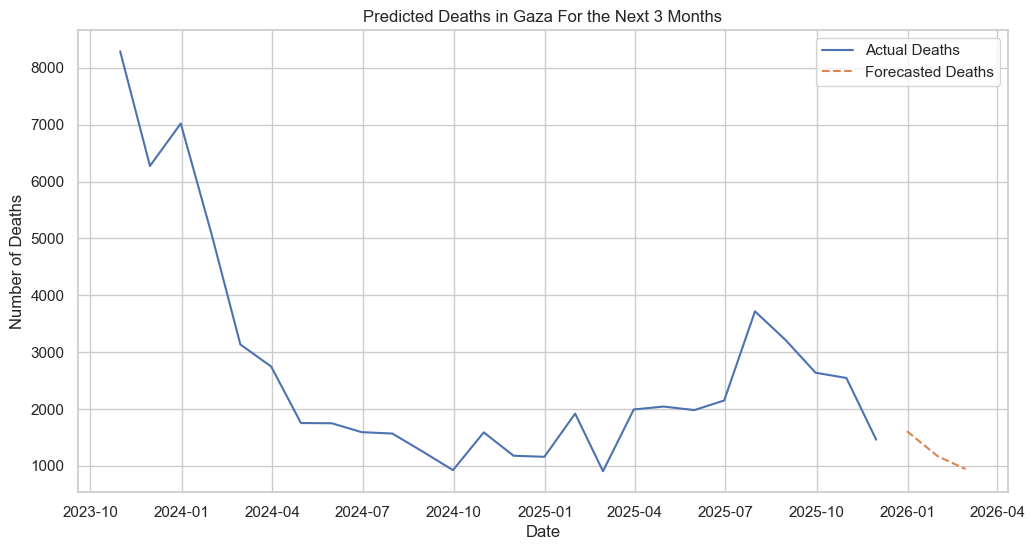

In [11]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(death_combined['ds'], death_combined['y'], label='Actual Deaths')
plt.plot(death_forecast['ds'], death_forecast['yhat'], label='Forecasted Deaths', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.title('Predicted Deaths in Gaza For the Next 3 Months')
plt.legend()
plt.show()

In [21]:
# Combine the actual and predicted data into a single DataFrame for better visualization
combined_death_forecast = pd.concat([death_combined, death_forecast], ignore_index=True)

# Rename y to "Actual Injuries" and yhat to "Predicted Injuries"
combined_death_forecast = combined_death_forecast.rename(columns={'y': 'Actual Deaths', 'yhat': 'Predicted Deaths'})

# Drop "Report Date", then rename "ds" to "Report Date"
combined_death_forecast = combined_death_forecast.drop(columns=['Report Date'], errors='ignore')
combined_death_forecast = combined_death_forecast.rename(columns={'ds': 'Report Date'})

combined_death_forecast

,Report Date,Actual Deaths,Predicted Deaths
0,2023-10-31,8293.0,NaN
1,2023-11-30,6275.0,NaN
2,2023-12-31,7022.0,NaN
3,2024-01-31,5078.0,NaN
4,2024-02-29,3135.0,NaN
5,2024-03-31,2747.0,NaN
6,2024-04-30,1753.0,NaN
7,2024-05-31,1749.0,NaN
8,2024-06-30,1593.0,NaN
9,2024-07-31,1568.0,NaN


# Injury Count Predictions

Using the existing injury count data, the ARIMA model will use the time series to predict injury counts over the next three and six month periods.

In [15]:
injury_combined, injury_forecast, injury_model = improved_forecast(
    casualties_monthly_data.iloc[:-1],
    date_col="Report Date",
    value_col="Ext Injured",
    steps=3
)
injury_combined.tail(10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=186.712, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=82.259, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=84.170, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=83.964, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=142.428, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=76.623, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=76.351, Time=0.00 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=80.175, Time=0.00 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=76.580, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=74.670, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=76.582, Time=0.01 sec
 ARIMA(

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/var/folders/27/hv6xxv915g7bd2pg98vnwdx40000gq/T/ipykernel_7331/2546154962.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),


,ds,Report Date,y,yhat
19,2025-05-31,2025-05-31,6040.0,NaN
20,2025-06-30,2025-06-30,9588.0,NaN
21,2025-07-31,2025-07-31,13447.0,NaN
22,2025-08-31,2025-08-31,13167.0,NaN
23,2025-09-30,2025-09-30,8280.0,NaN
24,2025-10-31,2025-10-31,2119.0,NaN
25,2025-11-30,2025-11-30,330.0,NaN
26,2025-12-31,NaT,NaN,944.894118
27,2026-01-31,NaT,NaN,1745.231118
28,2026-02-28,NaT,NaN,2496.847850


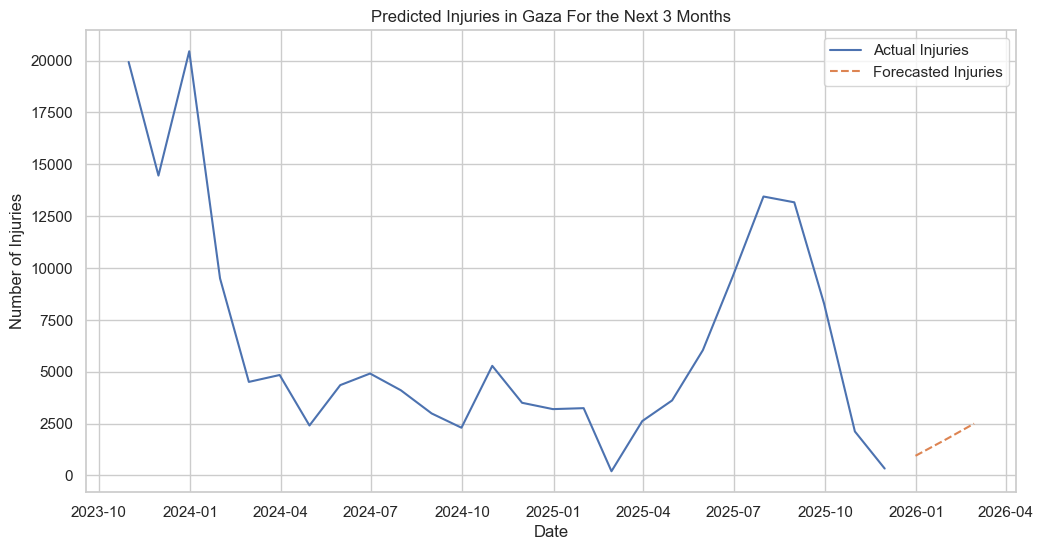

In [17]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(injury_combined['ds'], injury_combined['y'], label='Actual Injuries')
plt.plot(injury_forecast['ds'], injury_forecast['yhat'], label='Forecasted Injuries', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Injuries')
plt.title('Predicted Injuries in Gaza For the Next 3 Months')
plt.legend()
plt.show()

In [20]:
# Combine the actual and predicted data into a single DataFrame for better visualization
combined_injury_forecast = pd.concat([injury_combined, injury_forecast], ignore_index=True)

# Rename y to "Actual Injuries" and yhat to "Predicted Injuries"
combined_injury_forecast = combined_injury_forecast.rename(columns={'y': 'Actual Injuries', 'yhat': 'Predicted Injuries'})

# Drop "Report Date", then rename "ds" to "Report Date"
combined_injury_forecast = combined_injury_forecast.drop(columns=['Report Date'], errors='ignore')
combined_injury_forecast = combined_injury_forecast.rename(columns={'ds': 'Report Date'})

combined_injury_forecast

,Report Date,Actual Injuries,Predicted Injuries
0,2023-10-31,19933.0,NaN
1,2023-11-30,14457.0,NaN
2,2023-12-31,20451.0,NaN
3,2024-01-31,9498.0,NaN
4,2024-02-29,4508.0,NaN
5,2024-03-31,4841.0,NaN
6,2024-04-30,2406.0,NaN
7,2024-05-31,4353.0,NaN
8,2024-06-30,4912.0,NaN
9,2024-07-31,4104.0,NaN


# Infrastructure Destroyed and Damaged Count

The following gather data from Tech for Palestine on infrastructure damage and destruction counts, preprocess and standardize the column names, for use in forecasting.

In [22]:
# Fetch the JSON data from the URL
infrastructure_url = "https://data.techforpalestine.org/api/v3/infrastructure-damaged.json"
infrastructure_response = requests.get(infrastructure_url)
infrastructure_data = infrastructure_response.json()

# The first element of the list is the header (column names)
infrastructure_headers = infrastructure_data[0]

# The rest of the list contains the actual data rows
infrastructure_data_rows = infrastructure_data[1:]

# Create the DataFrame using the header and data rows
infrastructure_damaged = pd.DataFrame(infrastructure_data_rows, columns=infrastructure_headers)

# Display the first few rows of the properly structured DataFrame
print(infrastructure_damaged.head())

  report_date                         civic_buildings  \
0  2023-10-08                   {'ext_destroyed': 11}   
1  2023-10-09                   {'ext_destroyed': 16}   
2  2023-10-10                   {'ext_destroyed': 22}   
3  2023-10-11  {'destroyed': 27, 'ext_destroyed': 27}   
4  2023-10-12                   {'ext_destroyed': 29}   

                               educational_buildings  \
0            {'ext_destroyed': 1, 'ext_damaged': 30}   
1            {'ext_destroyed': 2, 'ext_damaged': 45}   
2            {'ext_destroyed': 2, 'ext_damaged': 60}   
3  {'destroyed': 3, 'ext_destroyed': 3, 'damaged'...   
4  {'destroyed': 3, 'ext_destroyed': 3, 'damaged'...   

                                   places_of_worship  \
0  {'ext_mosques_destroyed': 4, 'ext_mosques_dama...   
1  {'ext_mosques_destroyed': 6, 'ext_mosques_dama...   
2  {'ext_mosques_destroyed': 8, 'ext_mosques_dama...   
3  {'mosques_destroyed': 10, 'ext_mosques_destroy...   
4  {'mosques_destroyed': 10, 'ext_mosque

In [23]:
infrastructure_damaged.columns

Index(['report_date', 'civic_buildings', 'educational_buildings',
       'places_of_worship', 'residential'],
      dtype='object')

In [24]:
# Replace "_" with " " and capitalize each word in the column names
infrastructure_damaged.columns = [col.replace("_", " ").title() for col in infrastructure_damaged.columns]
infrastructure_damaged.columns

Index(['Report Date', 'Civic Buildings', 'Educational Buildings',
       'Places Of Worship', 'Residential'],
      dtype='object')

In [25]:
infrastructure_damaged.tail()

,Report Date,Civic Buildings,Educational Buildings,Places Of Worship,Residential
724,2025-10-01,{'ext_destroyed': 244},"{'ext_destroyed': 163, 'ext_damaged': 388}","{'ext_mosques_destroyed': 833, 'ext_churches_d...",{'ext_destroyed': 416000}
725,2025-10-02,{'ext_destroyed': 244},"{'ext_destroyed': 163, 'ext_damaged': 388}","{'ext_mosques_destroyed': 833, 'ext_churches_d...",{'ext_destroyed': 416000}
726,2025-10-03,{'ext_destroyed': 244},"{'ext_destroyed': 163, 'ext_damaged': 388}","{'ext_mosques_destroyed': 833, 'ext_churches_d...",{'ext_destroyed': 416000}
727,2025-10-04,{'ext_destroyed': 244},"{'ext_destroyed': 163, 'ext_damaged': 388}","{'ext_mosques_destroyed': 833, 'ext_churches_d...",{'ext_destroyed': 416000}
728,2025-10-05,"{'destroyed': 247, 'ext_destroyed': 247}","{'destroyed': 165, 'ext_destroyed': 165, 'dama...","{'mosques_destroyed': 835, 'ext_mosques_destro...","{'destroyed': 416000, 'ext_destroyed': 416000}"


In [26]:
# Extract the dictionaries in Civic Buildings, rename the columns to be prefixed by "Civic Buildings" and replace the Civil Buildings column with the extracted data
infrastructure_damaged_civic_buildings = pd.json_normalize(infrastructure_damaged["Civic Buildings"])
infrastructure_damaged_civic_buildings.columns = ["Civic Buildings " + col for col in infrastructure_damaged_civic_buildings.columns]
infrastructure_damaged = infrastructure_damaged.drop(columns=["Civic Buildings"]).join(infrastructure_damaged_civic_buildings)
infrastructure_damaged.head()

,Report Date,Educational Buildings,Places Of Worship,Residential,Civic Buildings ext_destroyed,Civic Buildings destroyed
0,2023-10-08,"{'ext_destroyed': 1, 'ext_damaged': 30}","{'ext_mosques_destroyed': 4, 'ext_mosques_dama...","{'destroyed': 159, 'ext_destroyed': 159}",11,NaN
1,2023-10-09,"{'ext_destroyed': 2, 'ext_damaged': 45}","{'ext_mosques_destroyed': 6, 'ext_mosques_dama...","{'destroyed': 790, 'ext_destroyed': 790}",16,NaN
2,2023-10-10,"{'ext_destroyed': 2, 'ext_damaged': 60}","{'ext_mosques_destroyed': 8, 'ext_mosques_dama...","{'destroyed': 1009, 'ext_destroyed': 1009}",22,NaN
3,2023-10-11,"{'destroyed': 3, 'ext_destroyed': 3, 'damaged'...","{'mosques_destroyed': 10, 'ext_mosques_destroy...","{'destroyed': 2835, 'ext_destroyed': 2835}",27,27.0
4,2023-10-12,"{'destroyed': 3, 'ext_destroyed': 3, 'damaged'...","{'mosques_destroyed': 10, 'ext_mosques_destroy...",{'ext_destroyed': 4188},29,NaN


In [27]:
# Extract the dictionaries in Educational Buildings, rename the columns to be prefixed by "Educational Buildings" and replace the Educational Buildings column with the extracted data
infrastructure_damaged_educational_buildings = pd.json_normalize(infrastructure_damaged["Educational Buildings"])
infrastructure_damaged_educational_buildings.columns = ["Educational Buildings " + col for col in infrastructure_damaged_educational_buildings.columns]
infrastructure_damaged = infrastructure_damaged.drop(columns=["Educational Buildings"]).join(infrastructure_damaged_educational_buildings)  
infrastructure_damaged.head()

,Report Date,Places Of Worship,Residential,Civic Buildings ext_destroyed,Civic Buildings destroyed,Educational Buildings ext_destroyed,Educational Buildings ext_damaged,Educational Buildings destroyed,Educational Buildings damaged
0,2023-10-08,"{'ext_mosques_destroyed': 4, 'ext_mosques_dama...","{'destroyed': 159, 'ext_destroyed': 159}",11,NaN,1,30,NaN,NaN
1,2023-10-09,"{'ext_mosques_destroyed': 6, 'ext_mosques_dama...","{'destroyed': 790, 'ext_destroyed': 790}",16,NaN,2,45,NaN,NaN
2,2023-10-10,"{'ext_mosques_destroyed': 8, 'ext_mosques_dama...","{'destroyed': 1009, 'ext_destroyed': 1009}",22,NaN,2,60,NaN,NaN
3,2023-10-11,"{'mosques_destroyed': 10, 'ext_mosques_destroy...","{'destroyed': 2835, 'ext_destroyed': 2835}",27,27.0,3,75,3.0,75.0
4,2023-10-12,"{'mosques_destroyed': 10, 'ext_mosques_destroy...",{'ext_destroyed': 4188},29,NaN,3,75,3.0,75.0


In [28]:
# Extract the dictionaries in Places Of Worship, rename the columns to be prefixed by "Places Of Worship" and replace the Places Of Worship column with the extracted data
infrastructure_damaged_places_of_worship = pd.json_normalize(infrastructure_damaged["Places Of Worship"])
infrastructure_damaged_places_of_worship.columns = ["Places Of Worship " + col for col in infrastructure_damaged_places_of_worship.columns]
infrastructure_damaged = infrastructure_damaged.drop(columns=["Places Of Worship"]).join(infrastructure_damaged_places_of_worship)  
infrastructure_damaged.head()

,Report Date,Residential,Civic Buildings ext_destroyed,Civic Buildings destroyed,Educational Buildings ext_destroyed,Educational Buildings ext_damaged,Educational Buildings destroyed,Educational Buildings damaged,Places Of Worship ext_mosques_destroyed,Places Of Worship ext_mosques_damaged,Places Of Worship ext_churches_destroyed,Places Of Worship mosques_destroyed,Places Of Worship mosques_damaged,Places Of Worship churches_destroyed
0,2023-10-08,"{'destroyed': 159, 'ext_destroyed': 159}",11,NaN,1,30,NaN,NaN,4,8.0,0,NaN,NaN,NaN
1,2023-10-09,"{'destroyed': 790, 'ext_destroyed': 790}",16,NaN,2,45,NaN,NaN,6,12.0,0,NaN,NaN,NaN
2,2023-10-10,"{'destroyed': 1009, 'ext_destroyed': 1009}",22,NaN,2,60,NaN,NaN,8,17.0,0,NaN,NaN,NaN
3,2023-10-11,"{'destroyed': 2835, 'ext_destroyed': 2835}",27,27.0,3,75,3.0,75.0,10,21.0,0,10.0,NaN,NaN
4,2023-10-12,{'ext_destroyed': 4188},29,NaN,3,75,3.0,75.0,10,25.0,0,10.0,NaN,NaN


In [29]:
# Extract the dictionaries in Residential Buildings, rename the columns to be prefixed by "Residential Buildings" and replace the Residential Buildings column with the extracted data
infrastructure_damaged_residential_buildings = pd.json_normalize(infrastructure_damaged["Residential"])
infrastructure_damaged_residential_buildings.columns = ["Residential Buildings " + col for col in infrastructure_damaged_residential_buildings.columns]
infrastructure_damaged = infrastructure_damaged.drop(columns=["Residential"]).join(infrastructure_damaged_residential_buildings)  
infrastructure_damaged.head()

,Report Date,Civic Buildings ext_destroyed,Civic Buildings destroyed,Educational Buildings ext_destroyed,Educational Buildings ext_damaged,Educational Buildings destroyed,Educational Buildings damaged,Places Of Worship ext_mosques_destroyed,Places Of Worship ext_mosques_damaged,Places Of Worship ext_churches_destroyed,Places Of Worship mosques_destroyed,Places Of Worship mosques_damaged,Places Of Worship churches_destroyed,Residential Buildings destroyed,Residential Buildings ext_destroyed
0,2023-10-08,11,NaN,1,30,NaN,NaN,4,8.0,0,NaN,NaN,NaN,159.0,159
1,2023-10-09,16,NaN,2,45,NaN,NaN,6,12.0,0,NaN,NaN,NaN,790.0,790
2,2023-10-10,22,NaN,2,60,NaN,NaN,8,17.0,0,NaN,NaN,NaN,1009.0,1009
3,2023-10-11,27,27.0,3,75,3.0,75.0,10,21.0,0,10.0,NaN,NaN,2835.0,2835
4,2023-10-12,29,NaN,3,75,3.0,75.0,10,25.0,0,10.0,NaN,NaN,NaN,4188


In [30]:
# Replace "_" with " " and capitalize each word in the column names
infrastructure_damaged.columns = [col.replace("_", " ").title() for col in infrastructure_damaged.columns]
infrastructure_damaged.columns

Index(['Report Date', 'Civic Buildings Ext Destroyed',
       'Civic Buildings Destroyed', 'Educational Buildings Ext Destroyed',
       'Educational Buildings Ext Damaged', 'Educational Buildings Destroyed',
       'Educational Buildings Damaged',
       'Places Of Worship Ext Mosques Destroyed',
       'Places Of Worship Ext Mosques Damaged',
       'Places Of Worship Ext Churches Destroyed',
       'Places Of Worship Mosques Destroyed',
       'Places Of Worship Mosques Damaged',
       'Places Of Worship Churches Destroyed',
       'Residential Buildings Destroyed',
       'Residential Buildings Ext Destroyed'],
      dtype='object')

In [31]:
infrastructure_damaged.tail()

,Report Date,Civic Buildings Ext Destroyed,Civic Buildings Destroyed,Educational Buildings Ext Destroyed,Educational Buildings Ext Damaged,Educational Buildings Destroyed,Educational Buildings Damaged,Places Of Worship Ext Mosques Destroyed,Places Of Worship Ext Mosques Damaged,Places Of Worship Ext Churches Destroyed,Places Of Worship Mosques Destroyed,Places Of Worship Mosques Damaged,Places Of Worship Churches Destroyed,Residential Buildings Destroyed,Residential Buildings Ext Destroyed
724,2025-10-01,244,NaN,163,388,NaN,NaN,833,NaN,3,NaN,NaN,NaN,NaN,416000
725,2025-10-02,244,NaN,163,388,NaN,NaN,833,NaN,3,NaN,NaN,NaN,NaN,416000
726,2025-10-03,244,NaN,163,388,NaN,NaN,833,NaN,3,NaN,NaN,NaN,NaN,416000
727,2025-10-04,244,NaN,163,388,NaN,NaN,833,NaN,3,NaN,NaN,NaN,NaN,416000
728,2025-10-05,247,247.0,165,392,165.0,392.0,835,NaN,3,835.0,NaN,3.0,416000.0,416000


In [32]:
# Aggregate date by month
infrastructure_damaged['Report Date'] = pd.to_datetime(infrastructure_damaged['Report Date'])
infrastructure_damaged.set_index('Report Date', inplace=True)
monthly_infrastructure_data = infrastructure_damaged.resample('M').sum()
monthly_infrastructure_data.reset_index(inplace=True)
monthly_infrastructure_data.head()

/var/folders/27/hv6xxv915g7bd2pg98vnwdx40000gq/T/ipykernel_7331/3147950050.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_infrastructure_data = infrastructure_damaged.resample('M').sum()


,Report Date,Civic Buildings Ext Destroyed,Civic Buildings Destroyed,Educational Buildings Ext Destroyed,Educational Buildings Ext Damaged,Educational Buildings Destroyed,Educational Buildings Damaged,Places Of Worship Ext Mosques Destroyed,Places Of Worship Ext Mosques Damaged,Places Of Worship Ext Churches Destroyed,Places Of Worship Mosques Destroyed,Places Of Worship Mosques Damaged,Places Of Worship Churches Destroyed,Residential Buildings Destroyed,Residential Buildings Ext Destroyed
0,2023-10-31,1032,27.0,522,3470,70.0,720.0,603,1342.0,16,20.0,0.0,0.0,81173.0,385932
1,2023-11-30,2676,88.0,1788,7257,60.0,238.0,2202,4464.0,65,67.0,145.0,3.0,569150.0,1287094
2,2023-12-31,3774,1587.0,2571,8661,1102.0,3910.0,3400,6099.0,93,1141.0,2749.0,39.0,777100.0,1730100
3,2024-01-31,4222,1348.0,2990,9132,954.0,2944.0,4591,7524.0,93,1419.0,2387.0,30.0,755500.0,2139850
4,2024-02-29,4252,883.0,2900,8646,700.0,2084.0,5554,7820.0,87,1154.0,1621.0,21.0,420000.0,2030000


In [33]:
monthly_infrastructure_data.tail()

,Report Date,Civic Buildings Ext Destroyed,Civic Buildings Destroyed,Educational Buildings Ext Destroyed,Educational Buildings Ext Damaged,Educational Buildings Destroyed,Educational Buildings Damaged,Places Of Worship Ext Mosques Destroyed,Places Of Worship Ext Mosques Damaged,Places Of Worship Ext Churches Destroyed,Places Of Worship Mosques Destroyed,Places Of Worship Mosques Damaged,Places Of Worship Churches Destroyed,Residential Buildings Destroyed,Residential Buildings Ext Destroyed
20,2025-06-30,6750,0.0,4290,10980,0.0,0.0,24840,6420.0,90,0.0,0.0,0.0,0.0,6300000
21,2025-07-31,6975,0.0,4615,11570,156.0,382.0,25738,6634.0,93,833.0,0.0,3.0,357000.0,8568000
22,2025-08-31,6975,0.0,4836,11842,0.0,0.0,25823,6634.0,93,0.0,0.0,0.0,0.0,11067000
23,2025-09-30,7225,244.0,4855,11610,163.0,388.0,24990,1284.0,90,833.0,0.0,3.0,416000.0,12185000
24,2025-10-31,1223,247.0,817,1944,165.0,392.0,4167,0.0,15,835.0,0.0,3.0,416000.0,2080000


In [34]:
# Consolidate the buildings damaged into a single column by looping through columns containing "damaged"
damaged_columns = [col for col in monthly_infrastructure_data.columns if 'Damaged' in col]
monthly_infrastructure_data['Total Buildings Damaged'] = monthly_infrastructure_data[damaged_columns].fillna(0).sum(axis=1)

# Consolidate the buildings destroyed into a single column by looping through columns containing "destroyed"
destroyed_columns = [col for col in monthly_infrastructure_data.columns if 'Destroyed' in col]
monthly_infrastructure_data['Total Buildings Destroyed'] = monthly_infrastructure_data[destroyed_columns].fillna(0).sum(axis=1)

# Drop the original columns
monthly_infrastructure_data = monthly_infrastructure_data.drop(columns=[
    *damaged_columns,
    *destroyed_columns
])

monthly_infrastructure_data = monthly_infrastructure_data.reset_index()
monthly_infrastructure_data.head()

,index,Report Date,Total Buildings Damaged,Total Buildings Destroyed
0,0,2023-10-31,5532.0,469395.0
1,1,2023-11-30,12104.0,1863193.0
2,2,2023-12-31,21419.0,2520907.0
3,3,2024-01-31,21987.0,2910997.0
4,4,2024-02-29,20171.0,2465551.0


# Infrastructure Destroyed Predictions

Using the existing infrastructure destroyed count data, the ARIMA model will use the time series to predict infrastructure destroyed counts over the next three and six month periods.

In [35]:
destroyed_combined, destroyed_forecast, destroyed_model = improved_forecast(
    monthly_infrastructure_data.iloc[:-1],
    date_col="Report Date",
    value_col="Total Buildings Destroyed",
    steps=3
)

# Rename y to "Actual Infrastructure Damaged" and yhat to "Predicted Infrastructure Damaged"    
destroyed_combined = destroyed_combined.rename(columns={'y': 'Actual Infrastructure Damaged', 'yhat': 'Predicted Infrastructure Damaged'})

# Drop "Report Date", then rename "ds" to "Report Date"
destroyed_combined = destroyed_combined.drop(columns=['Report Date'])
destroyed_combined = destroyed_combined.rename(columns={'ds': 'Report Date'})

destroyed_combined['Predicted Infrastructure Damaged'] = destroyed_combined['Predicted Infrastructure Damaged'].apply(lambda x: max(x, 0))
destroyed_combined.tail(10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13.707, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13.187, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14.122, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16.461, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15.138, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15.170, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16.835, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13.115, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=15.113, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15.114, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15.755, Time=0.00 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16.565, Time=0.01 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.149 seconds
                               SARIMAX Results     

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/var/folders/27/hv6xxv915g7bd2pg98vnwdx40000gq/T/ipykernel_7331/2546154962.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),


,Report Date,Actual Infrastructure Damaged,Predicted Infrastructure Damaged
17,2025-03-31,5243018.0,NaN
18,2025-04-30,5691954.0,NaN
19,2025-05-31,6758354.0,NaN
20,2025-06-30,6335970.0,NaN
21,2025-07-31,8963413.0,NaN
22,2025-08-31,11104727.0,NaN
23,2025-09-30,12639403.0,NaN
24,2025-10-31,NaN,1.396112e+07
25,2025-11-30,NaN,1.506976e+07
26,2025-12-31,NaN,1.598099e+07


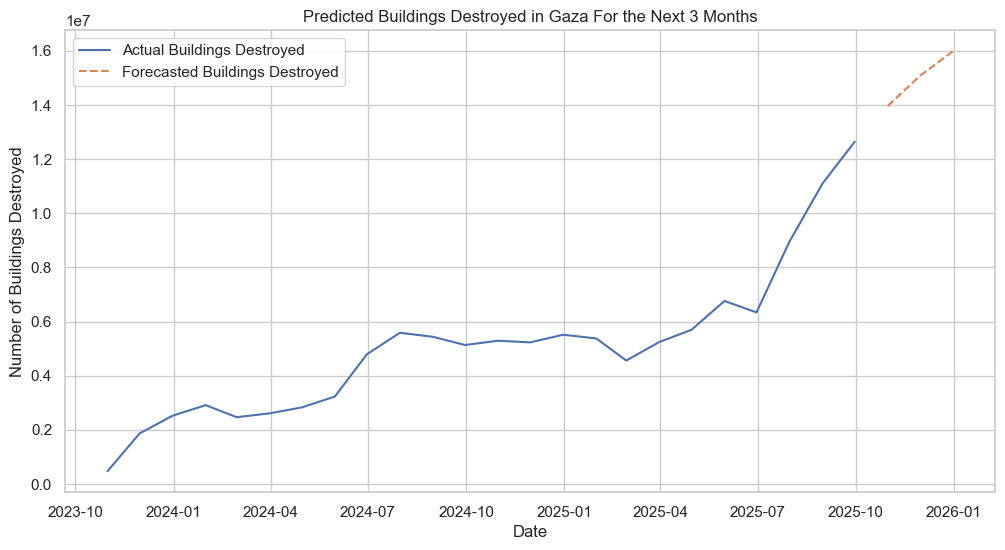

In [36]:
# Plot the actual buildings destroyed counts and the forecasted values (starting from the end of the dataset)
plt.figure(figsize=(12, 6))
plt.plot(destroyed_combined['Report Date'], destroyed_combined['Actual Infrastructure Damaged'], label='Actual Buildings Destroyed')
plt.plot(destroyed_combined['Report Date'], destroyed_combined['Predicted Infrastructure Damaged'], label='Forecasted Buildings Destroyed', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Buildings Destroyed')
plt.title('Predicted Buildings Destroyed in Gaza For the Next 3 Months')
plt.legend()
plt.show()

# Infrastructure Damaged Predictions

Using the existing infrastructure damaged count data, the ARIMA model will use the time series to predict infrastructure damaged counts over the next three and six month periods.

In [37]:
damaged_combined, damaged_forecast, damaged_model = improved_forecast(
    monthly_infrastructure_data.iloc[:-1],
    date_col="Report Date",
    value_col="Total Buildings Damaged",
    steps=3
)
damaged_combined = damaged_combined.rename(columns={'y': 'Actual Infrastructure Damaged', 'yhat': 'Predicted Infrastructure Damaged'})
damaged_combined = damaged_combined.drop(columns=['Report Date'])
damaged_combined = damaged_combined.rename(columns={'ds': 'Report Date'})
damaged_combined['Predicted Infrastructure Damaged'] = damaged_combined['Predicted Infrastructure Damaged'].apply(lambda x: max(x, 0))
damaged_combined.tail(10)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=0.805, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=179.553, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1.171, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=0.062, Time=0.01 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-0.150, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 0.233 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observation

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/var/folders/27/hv6xxv915g7bd2pg98vnwdx40000gq/T/ipykernel_7331/2546154962.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),


,Report Date,Actual Infrastructure Damaged,Predicted Infrastructure Damaged
17,2025-03-31,18078.0,NaN
18,2025-04-30,17619.0,NaN
19,2025-05-31,18332.0,NaN
20,2025-06-30,17400.0,NaN
21,2025-07-31,18586.0,NaN
22,2025-08-31,18476.0,NaN
23,2025-09-30,13282.0,NaN
24,2025-10-31,NaN,9921.361438
25,2025-11-30,NaN,8068.694204
26,2025-12-31,NaN,7968.560997


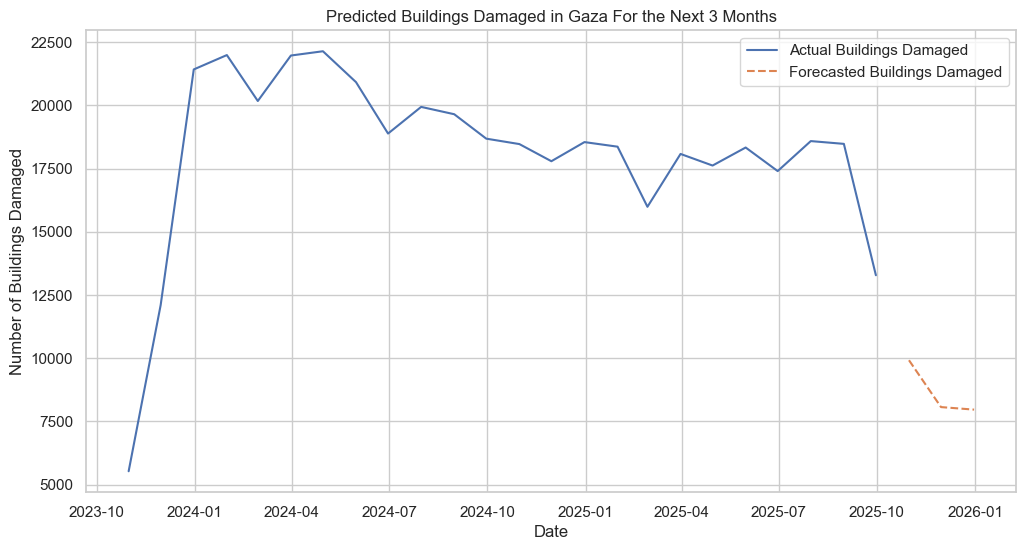

In [38]:
# Plot the actual buildings damaged counts and the forecasted values (starting from the end of the dataset)
plt.figure(figsize=(12, 6))
plt.plot(damaged_combined['Report Date'], damaged_combined['Actual Infrastructure Damaged'], label='Actual Buildings Damaged')
plt.plot(damaged_combined['Report Date'], damaged_combined['Predicted Infrastructure Damaged'], label='Forecasted Buildings Damaged', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Buildings Damaged')
plt.title('Predicted Buildings Damaged in Gaza For the Next 3 Months')
plt.legend()
plt.show()

# Power BI Report Script

The following is the script used to import data to the associated <a href="https://app.powerbi.com/reportEmbed?reportId=6e75fe72-d56c-47e3-9b89-e39d910eadce&autoAuth=true&ctid=9db3f0d7-245e-420f-8d3e-81ebe1ae6ff9" target="_blank">Palestinian Toll Predictions</a> Power BI dashboard.

<iframe title="Palestine Toll Predictions" width="100%" height="400" src="https://app.powerbi.com/reportEmbed?reportId=6e75fe72-d56c-47e3-9b89-e39d910eadce&autoAuth=true&ctid=9db3f0d7-245e-420f-8d3e-81ebe1ae6ff9" frameborder="0" allowFullScreen="true"></iframe>

    import pandas as pd
    import numpy as np
    import requests
    import seaborn as sns
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    import pmdarima as pm
    from pmdarima import auto_arima

    sns.set(style="whitegrid")

    def improved_forecast(df, date_col, value_col, steps=3, seasonal=False, m=12):
        # Prepare data
        data = df[[date_col, value_col]].dropna().copy()
        data['ds'] = pd.to_datetime(data[date_col])
        data = data.set_index('ds')
        y = data[value_col]

        # Log-transform to stabilize variance
        y_log = np.log1p(y)

        # Auto ARIMA search
        model = auto_arima(
            y_log,
            seasonal=seasonal,
            m=m,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True
        )

        print(model.summary())

        # Forecast
        forecast_log = model.predict(n_periods=steps)
        forecast = np.expm1(forecast_log)  # invert log1p

        # Forecast dates
        last_date = data.index.max()
        forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                    periods=steps, freq="M")

        # Build output DataFrame
        forecast_df = pd.DataFrame({
            'ds': forecast_dates,
            'yhat': forecast
        })

        # Combine actual + forecast
        combined = pd.concat([
            data.reset_index().rename(columns={'ds': 'ds', value_col: 'y'}),
            forecast_df
        ], ignore_index=True)

        return combined, forecast_df, model

    # Fetch the JSON data from the URL
    death_count_url = "https://data.techforpalestine.org/api/v2/casualties_daily.json"
    death_count_response = requests.get(death_count_url)
    death_count_data = death_count_response.json()

    # The first element of the list is the header (column names)
    death_count_headers = death_count_data[0]

    # The rest of the list contains the actual data rows
    death_count_rows = death_count_data[1:]

    # Create the DataFrame using the header and data rows
    death_counts = pd.DataFrame(death_count_rows, columns=death_count_headers)

    # Replace "_" with " " and capitalize each word in the column names
    death_counts.columns = [col.replace("_", " ").title() for col in death_counts.columns]

    # Aggregate date by month
    death_counts['Report Date'] = pd.to_datetime(death_counts['Report Date'])
    death_counts.set_index('Report Date', inplace=True)
    death_monthly_data = death_counts.resample('M').sum().drop("Report Source", axis=1)
    death_monthly_data.reset_index(inplace=True)

    death_combined, death_forecast, death_model = improved_forecast(
        death_monthly_data.iloc[:-1],
        date_col="Report Date",
        value_col="Ext Killed",
        steps=3
    )

    injury_combined, injury_forecast, injury_model = improved_forecast(
        death_monthly_data.iloc[:-1],
        date_col="Report Date",
        value_col="Ext Injured",
        steps=3
    )

    # Fetch the JSON data from the URL
    infrastructure_url = "https://data.techforpalestine.org/api/v3/infrastructure-damaged.json"
    infrastructure_response = requests.get(infrastructure_url)
    infrastructure_data = infrastructure_response.json()

    # The first element of the list is the header (column names)
    infrastructure_headers = infrastructure_data[0]

    # The rest of the list contains the actual data rows
    infrastructure_data_rows = infrastructure_data[1:]

    # Create the DataFrame using the header and data rows
    infrastructure_damaged = pd.DataFrame(infrastructure_data_rows, columns=infrastructure_headers)

    # Replace "_" with " " and capitalize each word in the column names
    infrastructure_damaged.columns = [col.replace("_", " ").title() for col in infrastructure_damaged.columns]
    infrastructure_damaged.columns

    # Extract the dictionaries in Civic Buildings, rename the columns to be prefixed by "Civic Buildings" and replace the Civil Buildings column with the extracted data
    infrastructure_damaged_civic_buildings = pd.json_normalize(infrastructure_damaged["Civic Buildings"])
    infrastructure_damaged_civic_buildings.columns = ["Civic Buildings " + col for col in infrastructure_damaged_civic_buildings.columns]
    infrastructure_damaged = infrastructure_damaged.drop(columns=["Civic Buildings"]).join(infrastructure_damaged_civic_buildings)

    # Extract the dictionaries in Educational Buildings, rename the columns to be prefixed by "Educational Buildings" and replace the Educational Buildings column with the extracted data
    infrastructure_damaged_educational_buildings = pd.json_normalize(infrastructure_damaged["Educational Buildings"])
    infrastructure_damaged_educational_buildings.columns = ["Educational Buildings " + col for col in infrastructure_damaged_educational_buildings.columns]
    infrastructure_damaged = infrastructure_damaged.drop(columns=["Educational Buildings"]).join(infrastructure_damaged_educational_buildings)  

    # Extract the dictionaries in Places Of Worship, rename the columns to be prefixed by "Places Of Worship" and replace the Places Of Worship column with the extracted data
    infrastructure_damaged_places_of_worship = pd.json_normalize(infrastructure_damaged["Places Of Worship"])
    infrastructure_damaged_places_of_worship.columns = ["Places Of Worship " + col for col in infrastructure_damaged_places_of_worship.columns]
    infrastructure_damaged = infrastructure_damaged.drop(columns=["Places Of Worship"]).join(infrastructure_damaged_places_of_worship)  

    # Extract the dictionaries in Residential Buildings, rename the columns to be prefixed by "Residential Buildings" and replace the Residential Buildings column with the extracted data
    infrastructure_damaged_residential_buildings = pd.json_normalize(infrastructure_damaged["Residential"])
    infrastructure_damaged_residential_buildings.columns = ["Residential Buildings " + col for col in infrastructure_damaged_residential_buildings.columns]
    infrastructure_damaged = infrastructure_damaged.drop(columns=["Residential"]).join(infrastructure_damaged_residential_buildings)  

    # Replace "_" with " " and capitalize each word in the column names
    infrastructure_damaged.columns = [col.replace("_", " ").title() for col in infrastructure_damaged.columns]

    # Aggregate date by month
    infrastructure_damaged['Report Date'] = pd.to_datetime(infrastructure_damaged['Report Date'])
    infrastructure_damaged.set_index('Report Date', inplace=True)
    monthly_infrastructure_data = infrastructure_damaged.resample('M').sum()
    monthly_infrastructure_data.reset_index(inplace=True)

    # Consolidate the buildings damaged into a single column by looping through columns containing "damaged"
    damaged_columns = [col for col in monthly_infrastructure_data.columns if 'Damaged' in col]
    monthly_infrastructure_data['Total Buildings Damaged'] = monthly_infrastructure_data[damaged_columns].fillna(0).sum(axis=1)

    # Consolidate the buildings destroyed into a single column by looping through columns containing "destroyed"
    destroyed_columns = [col for col in monthly_infrastructure_data.columns if 'Destroyed' in col]
    monthly_infrastructure_data['Total Buildings Destroyed'] = monthly_infrastructure_data[destroyed_columns].fillna(0).sum(axis=1)

    # Drop the original columns
    monthly_infrastructure_data = monthly_infrastructure_data.drop(columns=[
        *damaged_columns,
        *destroyed_columns
    ])
    monthly_infrastructure_data = monthly_infrastructure_data.reset_index()

    destroyed_combined, destroyed_forecast, destroyed_model = improved_forecast(
        monthly_infrastructure_data.iloc[:-1],
        date_col="Report Date",
        value_col="Total Buildings Destroyed",
        steps=3
    )

    damaged_combined, damaged_forecast, damaged_model = improved_forecast(
        monthly_infrastructure_data.iloc[:-1],
        date_col="Report Date",
        value_col="Total Buildings Damaged",
        steps=3
    )